In [1]:
import math
from pymongo import MongoClient
import pprint
import json
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
import numpy as np
import urllib.request, json 

In [100]:
class electricFence():
    def __init__(self):
        self.latitude = []
        self.longitude = []
        self.location = []
        self.frequency = {}
        self.chosenPoint = []
        self.user = ''
        
    def pullData(self, user): #pull latitude and longitude
        
        self.user = user
        
        client = MongoClient('120.126.136.17',27017)
        db = client['Tracker']
        collection = db[user]
        cursor = collection.find({})

        jsonData = [d for d in cursor]

        for x in jsonData:
            self.latitude.append(float(x['latitude']))
            self.longitude.append(float(x['longitude']))
            
    def onlySanxia(self):
        
        with urllib.request.urlopen("https://sheethub.com/ronnywang/%E9%84%89%E9%8E%AE%E5%B8%82%E5%8D%80%E8%A1%8C%E6%94%BF%E5%8D%80%E5%9F%9F%E7%95%8C%E7%B7%9A/uri/19260593?format=geojson") as url:
            data = json.loads(url.read().decode())
        
        # from scipy.spatial import ConvexHull
        boarderData = data['features'][0]['geometry']['coordinates'][0]
        
        #make out a path
        borderPath = mplPath.Path(boarderData) 
        
        for x in range(len(self.latitude)):
            if borderPath.contains_points(np.array([[self.longitude[x], self.latitude[x]]])):       
                self.location.append([round(self.latitude[x],4), round(self.longitude[x],4)])
                
    def removeOutlier(self):
        #remove that the variance is too large
        trainingset = np.array(self.location)
        mean = np.mean(trainingset, axis=0)
        sd = np.std(trainingset, axis=0)
        final_list = [x for x in self.location if ((x[0] > mean[0] - 6 * sd[0])and(x[1] > mean[1] - 6 * sd[1]))]
        final_list = [x for x in final_list if ((x[0] < mean[0] + 6 * sd[0])and(x[1] < mean[1] + 6 * sd[1]))]       
        self.location = final_list
        
    def abDistance(a, b):# calculate a and b distance  a[a緯, a經], b[b緯, b經]
        """
        兩點間距離D(x1,y1,x2,y2)=r×acos(sin(x1) ×sin(x2)+cos(x1) ×cos(x2) ×cos(y1-y2))
        x,y是緯度，經度的弧度單位，r是地球半徑
        """
        op = math.pi/180
        r = 6378.39
        return r*math.acos(math.sin(a[0]*op) * math.sin(b[0]*op) + 
                           math.cos(a[0]*op) * math.cos(b[0]*op) * math.cos(a[1]*op-b[1]*op))
    
    def addFrequency(self):#establish a dict to count how many duplicate location
        for x in self.location:
            if tuple(x) in self.frequency:
                self.frequency[tuple(x)] += 1
            else:
                self.frequency[tuple(x)] = 1
                
    def chosePoint(self):#point without duplicate
        for x in list(elFence.frequency.keys()):
            self.chosenPoint.append(list(x))
        return self.chosenPoint
    
    def squareBounds(self):
        downlat = 24.938590 
        leftlong = 121.360761
        toplat = 24.94884
        rightlong = 121.373937

        temptlist = [[round(x[0],3), round(x[1],3)] for x in self.location]
        
        squarefreq = []
        for i in range(int(round(toplat - downlat,3)*1000)):
            for j in range(int(round(rightlong - leftlong,3)*1000)):
                squarefreq[tuple([round(downlat + i/1000 ,3), round(leftlong + j/1000,3)])]=0

        for x in temptlist:
            if tuple(x) in squarefreq:
                squarefreq[tuple(x)] += 1
            else:
                squarefreq[tuple(x)] = 1

        boundlist = []

        for k,values in squarefreq.items():
            key = list(k)
            lt = [round(key[0] + 0.0005,4), round(key[1] - 0.0005,4)]
            rt = [round(key[0] + 0.0005,4), round(key[1] + 0.0005,4)]
            rd = [round(key[0] - 0.0005,4), round(key[1] + 0.0005,4)]
            ld = [round(key[0] - 0.0005,4), round(key[1] - 0.0005,4)]
            boundlist.append([lt,rt,rd,ld,values])
        return boundlist

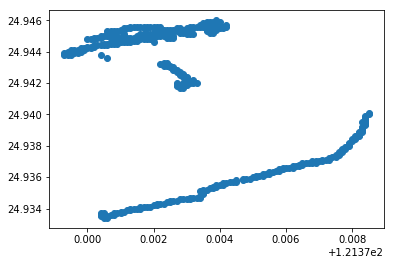

In [106]:
elFence = electricFence()
elFence.pullData('james')
elFence.onlySanxia()
elFence.removeOutlier()
boundlist = elFence.squareBounds()
elFence.addFrequency()
lis = elFence.chosePoint()# == (lis = elFence.chosenPoint)

trainingset = np.array(lis)
plt.plot(trainingset[:,1], trainingset[:,0], 'o')
plt.show()

In [109]:
boundlist[0]

[[24.9395, 121.3605],
 [24.9395, 121.3615],
 [24.9385, 121.3615],
 [24.9385, 121.3605],
 0]